# Test notebook to perform PCA on a TES data set

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from fastespy.readpydata import read_converted_pickle
from fastespy.plotting import plot_scatter_w_hist
import os
from tqdm import tqdm

In [2]:
%matplotlib inline

read and prepare the data 

In [3]:
datadir = "/Users/manuelmeyer/Python/TESdata/data-04202020/"

fitter = 'Rikhav'

if fitter == 'Rikhav':
    data_light_1 = list(np.load(os.path.join(datadir, 'Rikhav-Fits/light_triggers_cont_fitted.npy'), allow_pickle=True).tolist().values())
    data_extrinsic = list(np.load(os.path.join(datadir, 'Rikhav-Fits/ext1day2.npy'), allow_pickle=True).tolist().values())
    data_intrinsic = list(np.load(os.path.join(datadir, 'Rikhav-Fits/int7day.npy'), allow_pickle=True).tolist().values())

elif fitter == 'Manuel':    
    data_light_1 = read_converted_pickle(os.path.join(datadir, "lightdata-triggered-5s-20mV-1.pickle.bz2"),
                                         channel=0)

    data_light_2 = read_converted_pickle(os.path.join(datadir, "lightdata-triggered-5s-20mV-2.pickle.bz2"),
                                         channel=0)

    data_intrinsic = read_converted_pickle(os.path.join(datadir, "intrinsics-7day-50MHz-20mV.pickle.bz2"),
                                           channel=0)
                                       
    data_extrinsic = read_converted_pickle(os.path.join(datadir, "extrinsics-1day-50Mhz-20mV-1.pickle.bz2"),
                                           channel=0)
    
print (data_light_1[0]['data'].shape)
print (data_extrinsic[0]['data'].shape)
print (data_intrinsic[0]['data'].shape)

(4000,)
(10000,)
(10000,)


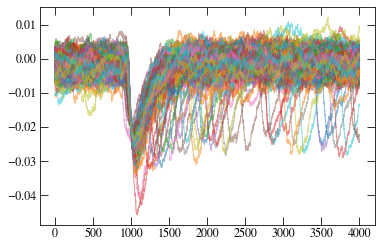

In [4]:
lo = 0
up = 4000

for i in range(1000):
    plt.plot(data_light_1[i]['data'][lo:up], alpha=0.5, lw=1)

In [64]:
def get_pulse_data(data, lo=0, up=-1):
    return np.array([data[i]['data'][lo:up] for i in range(len(data))])

def get_total_obs_time_sec(data):
    return data[-1]['time'][-1] - data[0]['time'][0]

print ("Obs time light 1: {0:.6f} s".format(get_total_obs_time_sec(data_light_1)))
#print ("Obs time light 2: {0:.6f} s".format(get_total_obs_time_sec(data_light_2)))
print ("Obs time intrinsic: {0:.6f} s".format(get_total_obs_time_sec(data_intrinsic)))
print ("Obs time extrinsic: {0:.6f} s".format(get_total_obs_time_sec(data_extrinsic)))
print ("Obs time intrinsic: {0:.6f} hrs".format(get_total_obs_time_sec(data_intrinsic) / 3600.))
print ("Obs time extrinsic: {0:.6f} hrs".format(get_total_obs_time_sec(data_extrinsic) / 3600.))


lo = None
up = None

X_signal = get_pulse_data(data_light_1, lo=lo, up=up)
#X = np.vstack([X, get_pulse_data(data_light_2, lo=lo, up=up)])
light_max = np.min(X)
print (light_max)

y_signal = np.ones(X_signal.shape[0]).astype(np.int)

print (X_signal.shape)

lo = None
up = data_light_1[0]['data'].size
#X_bkg = get_pulse_data(data_intrinsic, lo=lo, up=up)
#T_obs = get_total_obs_time_sec(data_intrinsic)

X_bkg = get_pulse_data(data_extrinsic, lo=lo, up=up)
T_obs = get_total_obs_time_sec(data_extrinsic)

X = np.vstack([X_signal, X_bkg])
y = np.append(y_signal, np.zeros(X_bkg.shape[0]).astype(np.int))

print (X_bkg.shape)
print (X.shape, y.shape)

Obs time light 1: 4.997961 s
Obs time intrinsic: 202832.210084 s
Obs time extrinsic: 78481.169177 s
Obs time intrinsic: 56.342281 hrs
Obs time extrinsic: 21.800325 hrs
-0.06757839322499427
(4547, 4000)
(1449, 4000)
(5996, 4000) (5996,)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=None,
                                                    test_size=0.2
                                                    )
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Perfrom PCA on light data set in training data set

In [66]:
pca = PCA(n_components=2)
pca_fit = pca.fit(X_train[y_train == 1].T)

In [67]:
print (pca_fit.components_.shape)
pca_factormatrix = np.dot(X_train[y_train == 1].T, pca_fit.components_.T)
print (pca_factormatrix.shape)
pca_rec_data = np.dot(pca_factormatrix, pca.components_)
print (pca_rec_data.shape, X_train[y_train == 1].T.shape)

(2, 3627)
(4000, 2)
(4000, 3627) (4000, 3627)


Text(0, 0.5, 'Voltage (a.u.)')

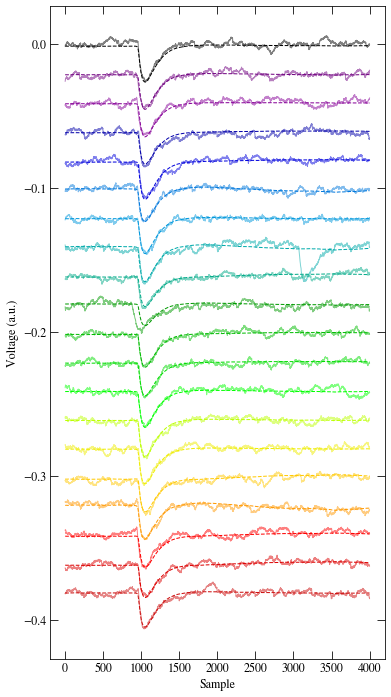

In [68]:
imax = 20
cp = plt.cm.nipy_spectral
shift = -0.02

fig = plt.figure(figsize=(6,12))

for i in range(imax):
    plt.plot(X_train[y_train == 1][i] + shift * i,
             color=cp(i / float(imax)),
             ls='-', lw=1, alpha=0.5
            )
    
    plt.plot(pca_rec_data.T[i] + shift * i,
             color=cp(i / float(imax)),
             ls='--', lw=1, alpha=1.
            )
plt.xlabel("Sample")
plt.ylabel("Voltage (a.u.)")

## Perfrom PCA on entire training set

In [69]:
pca = PCA(n_components=2)
pca_fit = pca.fit(X_train.T)

pca_factormatrix = np.dot(X_train.T, pca_fit.components_.T)
pca_rec_data = np.dot(pca_factormatrix, pca.components_)

Text(0, 0.5, 'Voltage (a.u.)')

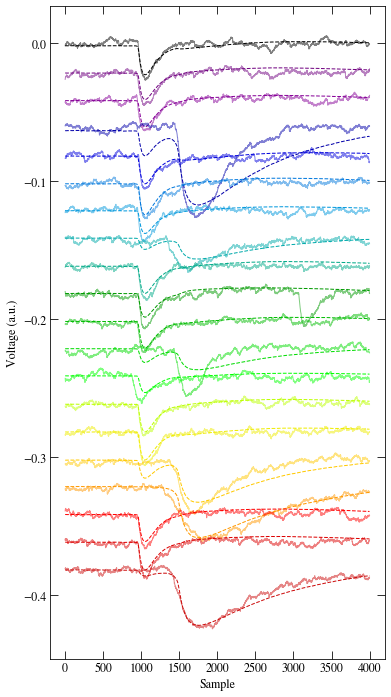

In [70]:
imax = 20
cp = plt.cm.nipy_spectral
shift = -0.02

fig = plt.figure(figsize=(6,12))

for i in range(imax):
    plt.plot(X_train[i] + shift * i,
             color=cp(i / float(imax)),
             ls='-', lw=1, alpha=0.5
            )
    
    plt.plot(pca_rec_data.T[i] + shift * i,
             color=cp(i / float(imax)),
             ls='--', lw=1, alpha=1.
            )
plt.xlabel("Sample")
plt.ylabel("Voltage (a.u.)")

In [71]:
X_train_trans = pca_fit.transform(X_train.T)
#X_test_trans = pca_fit.transform(X_test)

print (X_train_trans.shape)
print (pca_fit.components_.shape)

(4000, 2)
(2, 4796)


intrinsic_light


/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/plotting.py:317: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_2d = plt.axes(rect_scatter)
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/plotting.py:318: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_x = plt.axes(rect_histx)
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/plotting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a

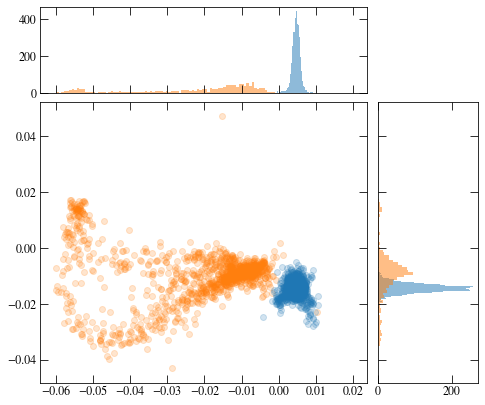

In [72]:
#label_points = ['extrinsic', 'light']
label_points = ['intrinsic', 'light']

prefix = '_'.join(label_points)
print (prefix)

fig = plt.figure(1, figsize=(7, 6))

for t in range(1,-1,-1):
    m = y_train == t
    fig, ax_2d, ax_x, ax_y, bins_x, bins_y = plot_scatter_w_hist(pca_fit.components_.T[m,0], pca_fit.components_.T[m,1],
                                                                 bins_x=100,
                                                                 bins_y=100,
                                                                 fig=fig,
                                                                 scatter_kwargs={"marker": 'o',
                                                                                 "alpha": 0.2,
                                                                                 "label": label_points[t],
                                                                                 "zorder": t
                                                                                 },
                                                                 hist_x_kwargs={"density": True, "alpha": 0.5},
                                                                 hist_y_kwargs={"density": True, "alpha": 0.5}
                                                                 )

In [35]:
pca_factormatrix = X_train_trans * pca_fit.components_.T

ValueError: operands could not be broadcast together with shapes (10000,2) (6644,2) 

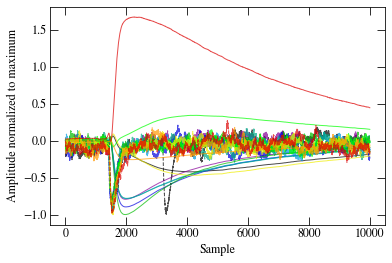

In [23]:
imax = 10
cp = plt.cm.nipy_spectral

for i in range(10):
    
    
    plt.plot(-1. * np.dot(X_train_trans, pca_fit.components_)[i,:] / \
                 np.abs(np.max(np.dot(X_train_trans, pca_fit.components_)[:imax,:])),
             color=cp(i / float(imax)),
             ls='-', lw=1, alpha=0.7
            )
    plt.plot(data_light_1[i]['data'][lo:up] / np.abs(np.min(X[:imax])),
             color = cp(i / float(imax)),
             ls='--', lw=1, alpha=0.7
            )
plt.ylabel("Amplitude normalized to maximum")
plt.xlabel("Sample")
plt.savefig("example_pca_pulses.png", dpi=150)

extrinsic_light


/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/plotting.py:317: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_2d = plt.axes(rect_scatter)
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/plotting.py:318: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_x = plt.axes(rect_histx)
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/plotting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a

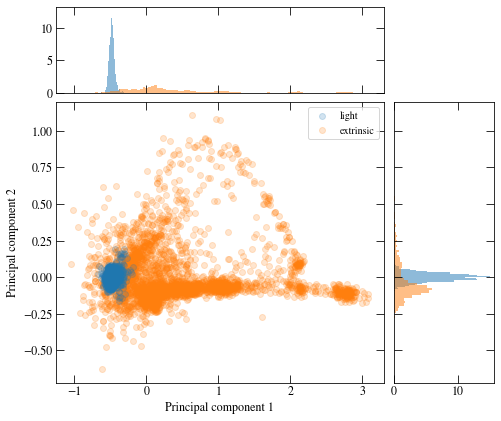

In [210]:
label_points = ['extrinsic', 'light']
#label_points = ['intrinsic', 'light']

prefix = '_'.join(label_points)
print (prefix)

fig = plt.figure(1, figsize=(7, 6))

for t in range(1,-1,-1):
    m = y_train == t
    fig, ax_2d, ax_x, ax_y, bins_x, bins_y = plot_scatter_w_hist(X_train_trans[m,0], X_train_trans[m,1],
                                                                 bins_x=100,
                                                                 bins_y=100,
                                                                 fig=fig,
                                                                 scatter_kwargs={"marker": 'o',
                                                                                 "alpha": 0.2,
                                                                                 "label": label_points[t],
                                                                                 "zorder": t
                                                                                 },
                                                                 hist_x_kwargs={"density": True, "alpha": 0.5},
                                                                 hist_y_kwargs={"density": True, "alpha": 0.5}
                                                                 )
ax_2d.legend()
ax_2d.set_xlabel("Principal component 1")
ax_2d.set_ylabel("Principal component 2")

plt.savefig(f"scatter_2d_pca_{prefix:s}.png", dpi=150)

## Perfrom the PCA transformation with $K$-Fold cross validation:

In [211]:
from sklearn.ensemble import RandomForestClassifier

In [212]:
default_pars = dict(
    rf={'criterion': 'gini',
        'max_depth': None,  # fully grown trees
        'n_estimators': 100,
        'min_samples_split': 2
        }
)

clf = RandomForestClassifier

In [213]:
n_components = np.arange(2, 102, 5)
print (n_components.shape)

(20,)


Split data into test, training, and validation sets:

In [214]:
X_train_test, X_valid, y_train_test, y_valid = train_test_split(X, y,
                                                                random_state=42,
                                                                stratify=None,
                                                                test_size=0.2
                                                                )

In [215]:
train_score, test_score = [], []

for n in tqdm(n_components):
    
    pars = default_pars['rf']
    pars['max_features'] = np.floor(np.sqrt(n)).astype(np.int)

    train_score.append([])
    test_score.append([])
    
    for train_index, test_index in kf.split(X_train_test):
        
        X_train, X_test = X_train_test[train_index], X_train_test[test_index]
        y_train, y_test = y_train_test[train_index], y_train_test[test_index]
          
        # perform PCA
        pca = PCA(n_components=n)
        pca_fit = pca.fit(X_train)
        X_train_trans = pca_fit.transform(X_train)
        X_test_trans = pca_fit.transform(X_test)
        
        # Perform classification
        clf = RandomForestClassifier(**pars)
        clf.fit(X_train_trans, y_train)
        
        # save the scores
        train_score[-1].append(clf.score(X_train_trans, y_train))
        test_score[-1].append(clf.score(X_test_trans, y_test))


100%|██████████| 20/20 [03:58<00:00, 11.90s/it]


In [216]:
train_score = np.array(train_score)
test_score = np.array(test_score)

print (train_score.shape)

(20, 5)


### Plot the results from the cross validation

0.9881095488046997 12


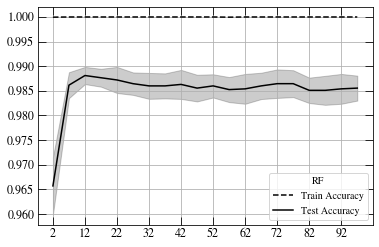

In [217]:
plt.plot(n_components, train_score.mean(axis=1),
         ls='--',
         color='k',
         label='Train Accuracy')

plt.plot(n_components, test_score.mean(axis=1),
         ls='-',
         color='k',
         label='Test Accuracy')

best_components = n_components[np.argmax(test_score.mean(axis=1))]
print (test_score.mean(axis=1).max(), n_components[np.argmax(test_score.mean(axis=1))])

plt.fill_between(n_components, test_score.mean(axis=1) + np.sqrt(test_score.var(axis=1)),
                 y2=test_score.mean(axis=1) - np.sqrt(test_score.var(axis=1)),
                 color='k',
                 alpha=0.2)

_ = plt.xticks(n_components[::2])

plt.grid(True)

plt.legend(title='RF')

plt.savefig(f"rf_pca_{prefix:s}.png", dpi=150)

With best number of components, train classifier again and calculate validation score

In [218]:
pars['max_features'] = np.floor(np.sqrt(best_components)).astype(np.int)

# perform PCA
pca = PCA(n_components=best_components)
pca_fit = pca.fit(X_train_test)
X_train_test_trans = pca_fit.transform(X_train_test)
X_valid_trans = pca_fit.transform(X_valid)
        
# Perform classification
clf = RandomForestClassifier(**pars)
clf.fit(X_train_test_trans, y_train_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [219]:
"Achieved Accuracy on validation sample: {0:.5f}".format(clf.score(X_valid_trans, y_valid))

'Achieved Accuracy on validation sample: 0.98856'

In [220]:
"Achieved bkg rate: {0:.5e} Hz".format((1. - clf.score(X_valid_trans, y_valid)) * X_bkg.shape[0] / T_obs)

'Achieved bkg rate: 7.45166e-04 Hz'